##### Model: Decision Tree
Kelas : IF - E  
NIM / Nama  
123230010 / Rendi Wahyu N  
123230013 / Valentino Abinata  
123230018 / Imam Khusain  

Import library yang dibutuhkan

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, average_precision_score,
                             precision_recall_fscore_support, roc_curve, precision_recall_curve)

Potongan Kode yang Dibutuhkan Dari Kode Sebelumnya

In [74]:
# Baca dataset Heart Failure Clinical Records, yang terdapat dalam "https://www.kaggle.com/datasets/rabieelkharoua/predict-survival-of-patients-with-heart-failure/data"
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
categorical_columns = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"] 
numerical_columns = ["age","creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium","time", "DEATH_EVENT"]

Memisahkan feature dan target ('DEATH_EVENT')

In [75]:
X = df.drop(['DEATH_EVENT', 'time'], axis=1)  # Drop target dan kolom time
y = df['DEATH_EVENT']  # Target variable

print(f"Shape X (fitur): {X.shape}")
print(f"Shape y (target): {y.shape}")
print(f"Distribusi kelas target:\n{y.value_counts()}")
print(f"Persentase kelas 1 (meninggal): {y.mean():.2%}")

Shape X (fitur): (299, 11)
Shape y (target): (299,)
Distribusi kelas target:
DEATH_EVENT
0    203
1     96
Name: count, dtype: int64
Persentase kelas 1 (meninggal): 32.11%


Pre Processing Pipeline Menggunakan:
- Log Transform sebagai Transformasi Data
- Robust Scaler sebagai Normalisasi/ Scaling

In [76]:
def log_transform(X):
    return np.log1p(X)

# PipeLine preprocessing
preprocessor = ColumnTransformer([
    ('log_num', Pipeline([
        ('log', FunctionTransformer(log_transform)),
        ('scaler', RobustScaler())
    ]), ['creatinine_phosphokinase', 'serum_creatinine', 'platelets']),
   
    ('robust_num', RobustScaler(),
     ['age', 'ejection_fraction', 'serum_sodium']),  # time dihapus
   
    ('cat', 'passthrough', categorical_columns) # sudah binary
])

# Full pipeline
dt_pipeline = Pipeline([
    ('prep', preprocessor),
    ('dt', DecisionTreeClassifier(
        random_state=42,
        class_weight='balanced'
    ))
])

Train-Test Split

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Data train: {X_train.shape}")
print(f"Data test: {X_test.shape}")
print(f"Distribusi kelas di train set:\n{y_train.value_counts()}")
print(f"Distribusi kelas di test set:\n{y_test.value_counts()}")
print(f"Persentase kematian di test set: {y_test.mean():.2%}")

Data train: (239, 11)
Data test: (60, 11)
Distribusi kelas di train set:
DEATH_EVENT
0    162
1     77
Name: count, dtype: int64
Distribusi kelas di test set:
DEATH_EVENT
0    41
1    19
Name: count, dtype: int64
Persentase kematian di test set: 31.67%


Hypermeter Tuning

In [78]:
param_dist = {
    'dt__max_depth': [None, 3, 5, 7, 10, 15],
    'dt__min_samples_split': [2, 5, 10, 20],
    'dt__min_samples_leaf': [1, 2, 4, 8],
    'dt__max_features': ['sqrt', 'log2', None, 0.5]
}
random_search = RandomizedSearchCV(
    dt_pipeline, param_distributions=param_dist,
    n_iter=50, cv=StratifiedKFold(5), scoring='roc_auc',
    random_state=42, n_jobs=-1, verbose=0
)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print("\nBest parameters:")
print(random_search.best_params_)
print(f"Best CV ROC-AUC: {random_search.best_score_:.4f}")


Best parameters:
{'dt__min_samples_split': 20, 'dt__min_samples_leaf': 1, 'dt__max_features': None, 'dt__max_depth': 15}
Best CV ROC-AUC: 0.7507


Evaluasi

In [79]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

print("\n" + "="*60)
print(" HASIL AKHIR DECISION TREE")
print("="*60)
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"ROC-AUC : {roc_auc:.4f}")
print(f"PR-AUC : {pr_auc:.4f}")
print("="*60)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['Bertahan', 'Meninggal']))


 HASIL AKHIR DECISION TREE
Accuracy : 0.7333
Precision : 0.5556
Recall : 0.7895
F1-Score : 0.6522
ROC-AUC : 0.7908
PR-AUC : 0.6049

Classification Report:
              precision    recall  f1-score   support

    Bertahan       0.88      0.71      0.78        41
   Meninggal       0.56      0.79      0.65        19

    accuracy                           0.73        60
   macro avg       0.72      0.75      0.72        60
weighted avg       0.78      0.73      0.74        60



Confusion Matrix

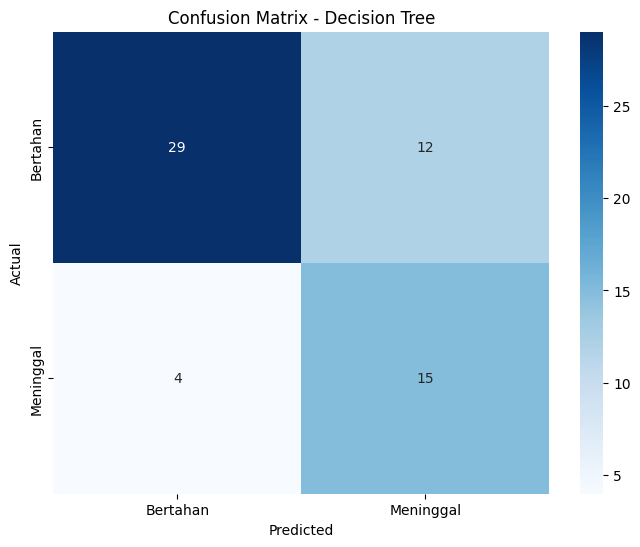

In [80]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bertahan', 'Meninggal'],
            yticklabels=['Bertahan', 'Meninggal'])
plt.title('Confusion Matrix - Decision Tree')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

ROC (Receiver Operating Characteristic) Curve

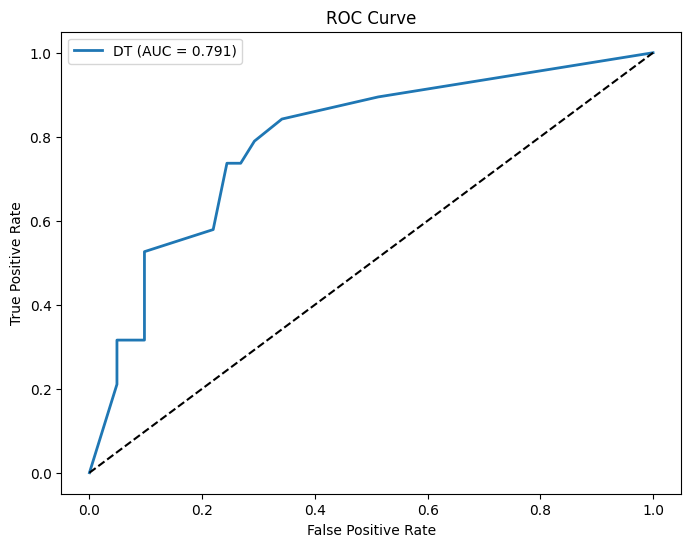

In [81]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'DT (AUC = {roc_auc:.3f})', lw=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Precision-Recall Curve

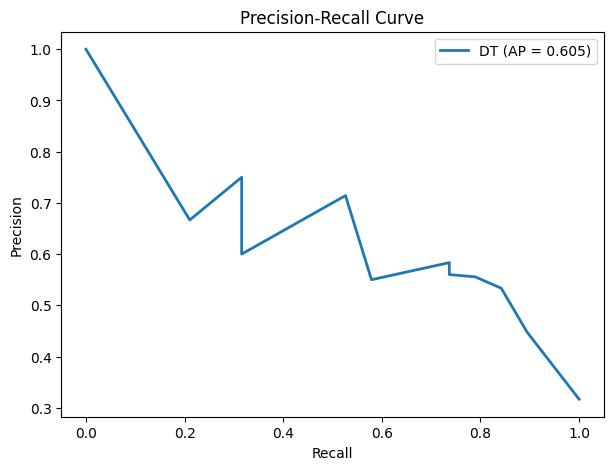

In [82]:
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

plt.figure(figsize=(7, 5))
plt.plot(recall_curve, precision_curve, label=f'DT (AP = {pr_auc:.3f})', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

Feature Importance


Feature Importance:
anaemia                     0.340016
ejection_fraction           0.235256
diabetes                    0.130112
high_blood_pressure         0.110145
creatinine_phosphokinase    0.069153
age                         0.061259
sex                         0.033325
smoking                     0.020734
platelets                   0.000000
serum_sodium                0.000000
serum_creatinine            0.000000
dtype: float64


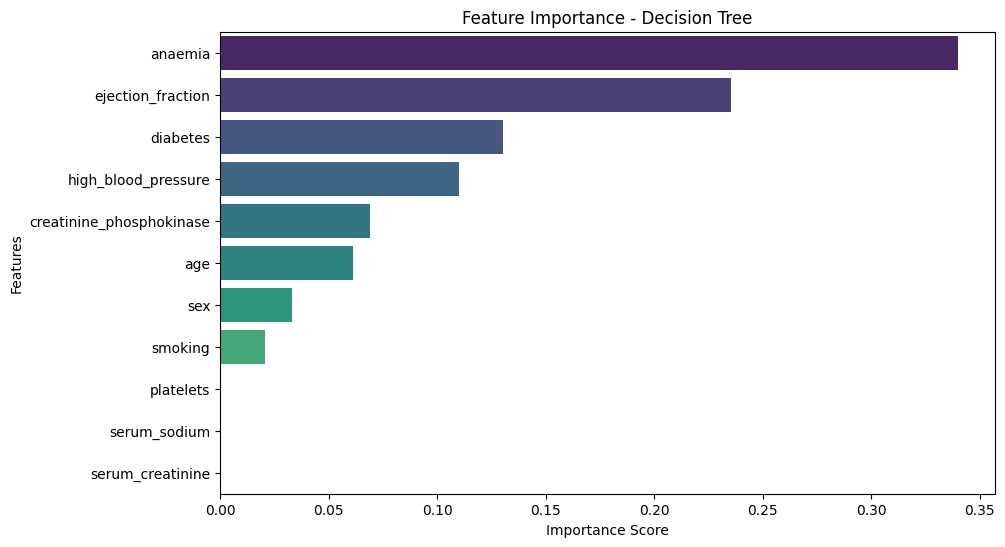

In [83]:
feature_names = X.columns
importances = best_model.named_steps['dt'].feature_importances_
feature_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("\nFeature Importance:")
print(feature_imp)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index, palette='viridis')
plt.title('Feature Importance - Decision Tree')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

Learning Curve

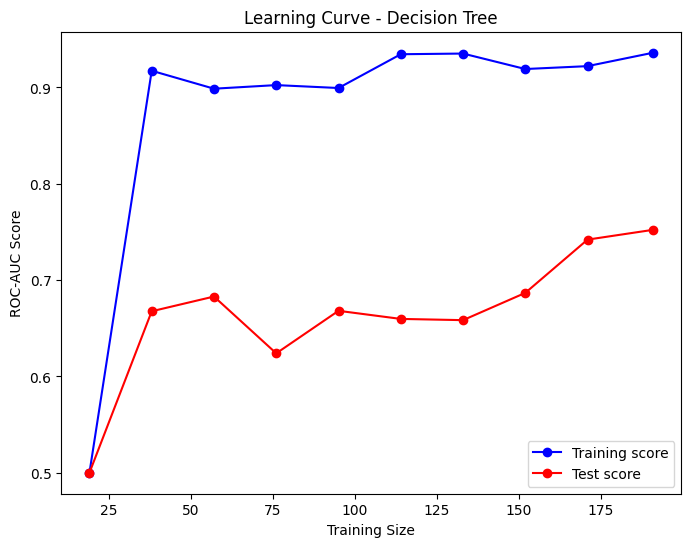

In [84]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='red', label='Test score')
plt.title('Learning Curve - Decision Tree')
plt.xlabel('Training Size')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.show()

Visualisasi Decision Tree

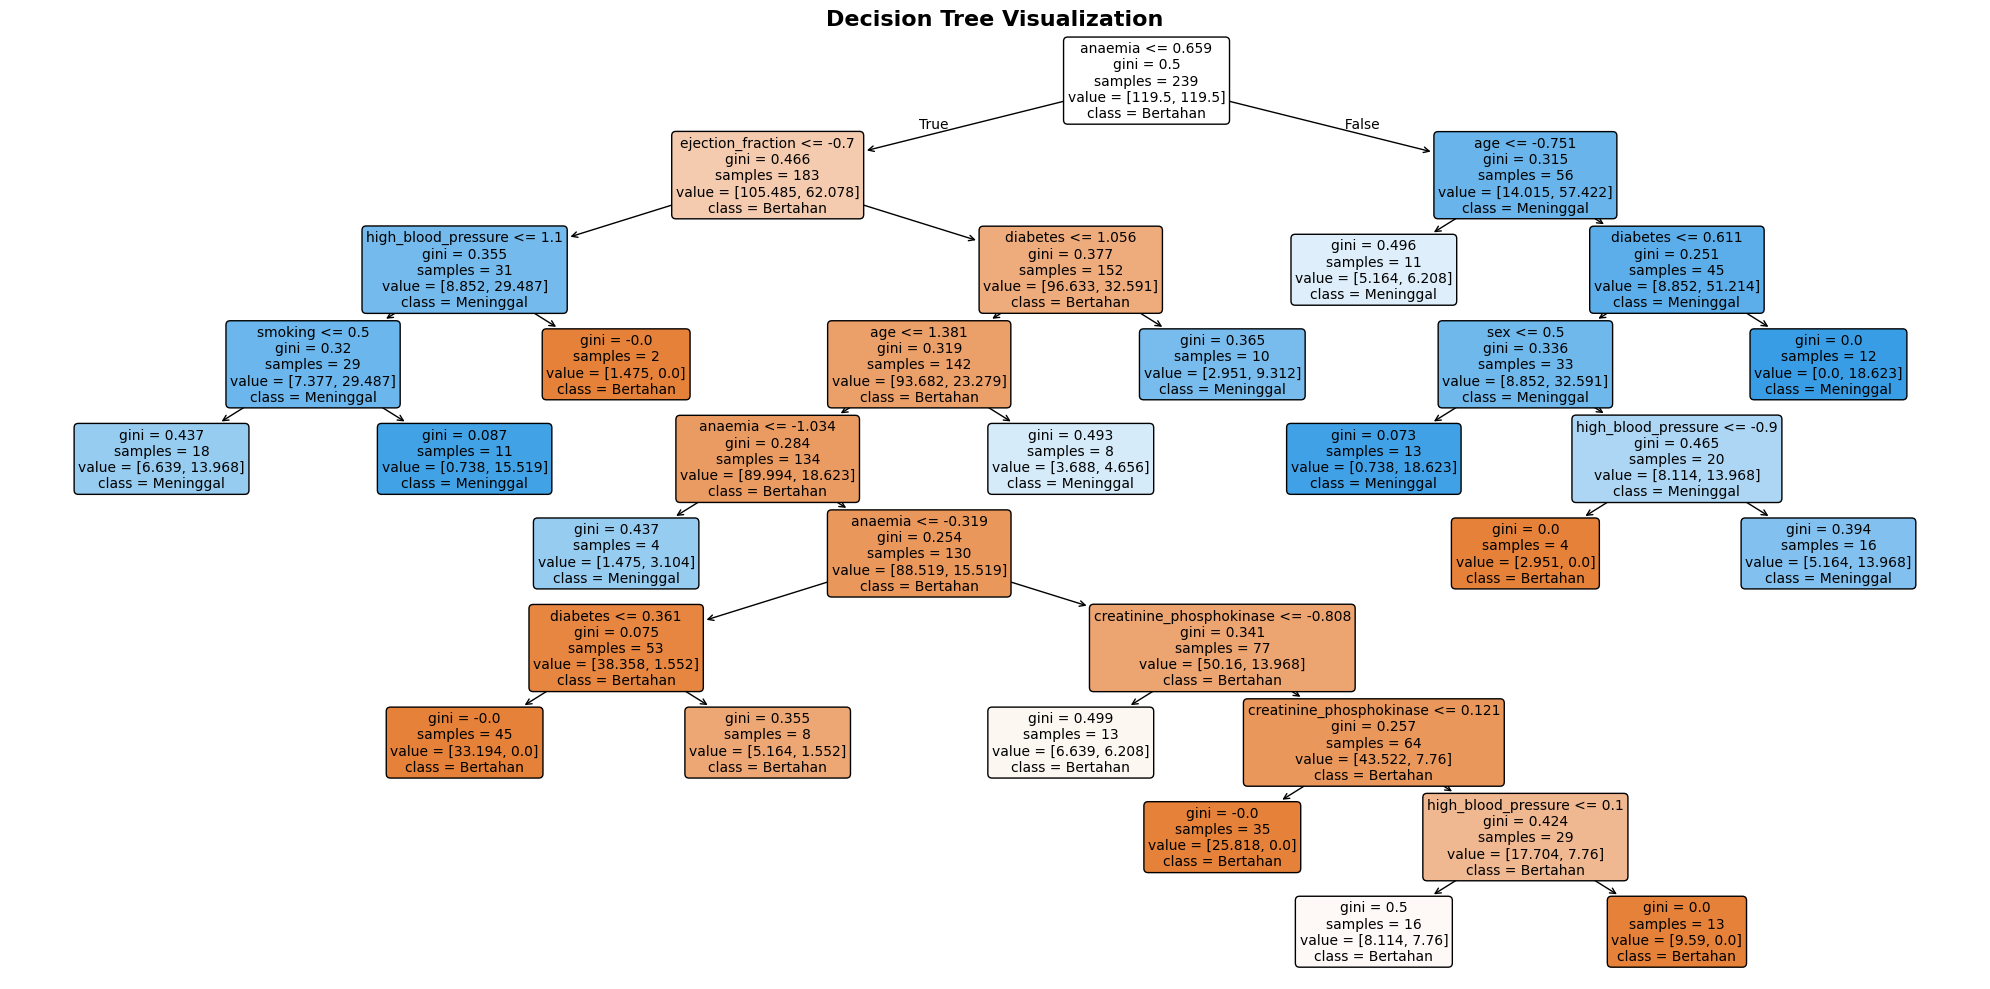

In [85]:
plt.figure(figsize=(20, 10))
plot_tree(best_model.named_steps['dt'], 
          feature_names=feature_names,
          class_names=['Bertahan', 'Meninggal'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Decision Tree Visualization', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Decision Tree Complexity

In [86]:
dt_model = best_model.named_steps['dt']

print("Model Complexity - Decision Tree:")
print(f"Tree depth: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")
print(f"Number of nodes: {dt_model.tree_.node_count}")

Model Complexity - Decision Tree:
Tree depth: 9
Number of leaves: 17
Number of nodes: 33


Simulasi Menginputkan Data Baru

In [87]:
new_data = {
    'age': [50.0], # Usia pasien
    'anaemia': [0], # 0 atau 1 (ada anemia atau tidak)
    'creatinine_phosphokinase': [582], # Level CPK
    'diabetes': [0], # 0 atau 1
    'ejection_fraction': [40], # Persentase ejection fraction
    'high_blood_pressure': [0], # 0 atau 1
    'platelets': [265000.0], # Jumlah platelets
    'serum_creatinine': [1.0], # Level serum creatinine
    'serum_sodium': [135], # Level serum sodium
    'sex': [1], # 1 untuk pria, 0 untuk wanita
    'smoking': [0] # 0 atau 1
}

new_df = pd.DataFrame(new_data)

# Prediksi
new_pred = best_model.predict(new_df)
new_proba = best_model.predict_proba(new_df)[:, 1]

print("\nContoh Prediksi dengan Input Manual:")
print(f"Features: {new_data}")
print(f"Predicted: {new_pred[0]} (0: Bertahan, 1: Meninggal)")
print(f"Probability of Death: {new_proba[0]:.4f}")


Contoh Prediksi dengan Input Manual:
Features: {'age': [50.0], 'anaemia': [0], 'creatinine_phosphokinase': [582], 'diabetes': [0], 'ejection_fraction': [40], 'high_blood_pressure': [0], 'platelets': [265000.0], 'serum_creatinine': [1.0], 'serum_sodium': [135], 'sex': [1], 'smoking': [0]}
Predicted: 0 (0: Bertahan, 1: Meninggal)
Probability of Death: 0.0000
